# Analise Exploratoria e teste dos dataloaders para os Datasets Propostos


Fazer analise dos dados. Analise estatistica que indique a diferença entre os dados, desvios parao, outliers, diferença entre os pixeis e de alguma forma demosntrar como o gap de dominios esta presente neste caso. Talvez algum algoritmo de classificação mais basico ou algo que avalie as caracteristicas e plote elas em uma imagem.

Para mostrar cientificamente as diferenças nos domínios de datasets subaquáticos e datasets atmosféricos no contexto de adaptação de domínio, você pode usar as seguintes abordagens com gráficos:

1. Distribuição de Histogramas

O que mostrar: Compare os histogramas de intensidade (luminância) e cores (canais RGB) dos dois domínios. Isso ajuda a visualizar as diferenças na distribuição de cores e luminosidade.
Gráfico: Histogramas sobrepostos ou separados para cada canal de cor.
Ferramenta: matplotlib ou seaborn em Python.

2. Visualização em Espaços de Cor

O que mostrar: Projete os dados dos dois domínios em um espaço de cor, como CIELAB ou HSV, para analisar como os clusters de cor se distribuem.
Gráfico: Scatter plot em 2D ou 3D (ex.: Lab* ou H-S).
Ferramenta: plotly ou matplotlib.

3. Análise de Features com PCA ou t-SNE

O que mostrar: Extraia características de baixo nível (ex.: textura, contraste, cor) ou alto nível (ex.: features de redes neurais) e use PCA (Principal Component Analysis) ou t-SNE para reduzir as dimensões. Visualize como os clusters de dados subaquáticos e atmosféricos estão separados ou sobrepostos.
Gráfico: Scatter plot dos componentes principais ou projeções 2D/3D.
Ferramenta: scikit-learn e matplotlib.

4. Diferenças Estatísticas

O que mostrar: Calcule e visualize métricas como desvio padrão, média e kurtose de atributos visuais (ex.: contraste, saturação). Isso ajuda a quantificar diferenças.
Gráfico: Boxplot ou violin plot para cada métrica.
Ferramenta: seaborn ou pandas.

5. Comparação de Textura e Frequência

O que mostrar: Aplique transformadas de Fourier ou wavelets para comparar a densidade de alta/baixa frequência entre os datasets.
Gráfico: Densidade espectral de potência ou heatmaps.
Ferramenta: numpy e matplotlib.

6. Visualização de Similaridade (Heatmap ou Matriz de Confusão)

O que mostrar: Use uma métrica de distância (ex.: SSIM, MSE ou perceptual loss) para quantificar similaridades entre imagens dos dois domínios.
Gráfico: Heatmap de similaridade ou um gráfico de linhas com as diferenças médias.
Ferramenta: seaborn ou matplotlib.

## Dataloader

In [9]:
from utils.utils import *
import math
tam = load_RUIE_paths()
print(len(tam[0]),len(tam[1]),len(tam[2]), len(tam[0]) + len(tam[1]) + len(tam[2]))

2662 762 380 3804


In [1]:
from utils.utils import *
from torch.utils.data import DataLoader

load_train = Underwater_Dataset(underwater_dataset_name="UIEB")
train_dataset_underwater = DataLoader(load_train, batch_size= 8,
                        shuffle=True, num_workers=4,
                        drop_last=True, pin_memory=True)
    ###carrega o modelo com as configuracoes indicadas )
load_train_2 = Atmospheric_Dataset(atmospheric_dataset_name="HDR+")
train_dataset_atmospheric = DataLoader(load_train_2, batch_size= 8,
                        shuffle=True, num_workers=4,
                        drop_last=True, pin_memory=True)





# Analise dos dados

A seguir, segue uma função em Python que permite realizar as análises sugeridas com base em um DataLoader do PyTorch. Essa função foi estruturada de forma modular para cobrir cada técnica de análise:

* Distribuição de Histogramas
* Visualização em Espaços de Cor
* Análise de Features com PCA ou t-SNE
* Diferenças Estatísticas
* Comparação de Textura e Frequência
* Visualização de Similaridade (Heatmap ou Matriz de Confusão)

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from skimage.color import rgb2lab
from skimage.feature import graycomatrix, graycoprops
from skimage.metrics import structural_similarity as ssim
from scipy.fftpack import fft2, fftshift
import torch
from tqdm.notebook import tqdm as tqdm

def analyze_dataset(dataloader, dataset_name):
    """
    Perform several analyses on a dataset to visualize its characteristics.
    
    Parameters:
    - dataloader: PyTorch DataLoader object
    - dataset_name: Name of the dataset (for labeling)
    """
    print(f"\nAnalise de dados do dataset {dataset_name}\n")
    # Store data for processing
    images = []
    print(f"Carregando imagens do DataLoader {len(dataloader)}")
    # Load images from DataLoader
    for imgs in tqdm(dataloader):
         # Assuming DataLoader yields (images, labels)
        images.append(imgs)
    

    images = torch.cat(images, dim=0).numpy()  # Convert to numpy array
    images = np.transpose(images, (0, 2, 3, 1))  # Change to (N, H, W, C)

    # -------------------------------
    # 1. Distribution of Histograms
    # -------------------------------
    plt.figure(figsize=(15, 5))
    for i, channel in enumerate(['Red', 'Green', 'Blue']):
        channel_values = images[:, :, :, i].flatten()
        plt.subplot(1, 3, i+1)
        sns.histplot(channel_values, bins=50, color=channel.lower(), kde=True)
        plt.title(f"{dataset_name} - {channel} Histogram")
        plt.xlabel('Intensity')
        plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()
    
    # ---------------------------------
    # 2. Visualization in Color Space
    # ---------------------------------
    lab_images = np.array([rgb2lab(img) for img in images])  # Convert to LAB space
    plt.figure(figsize=(10, 7))
    plt.scatter(lab_images[:, :, :, 1].flatten(), lab_images[:, :, :, 2].flatten(), alpha=0.1, color='purple')
    plt.title(f"{dataset_name} - a*b* Color Space")
    plt.xlabel('a* (green-red)')
    plt.ylabel('b* (blue-yellow)')
    plt.show()
    
    # ----------------------------------------
    # 3. PCA or t-SNE for Feature Analysis
    # ----------------------------------------
    reshaped_images = images.reshape(images.shape[0], -1)  # Flatten images
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(reshaped_images)
    
    plt.figure(figsize=(10, 7))
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], alpha=0.5)
    plt.title(f"{dataset_name} - PCA Projection")
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()
    
    # --------------------------------------
    # 4. Statistical Differences (Boxplots)
    # --------------------------------------
    stats = {
        'Mean': np.mean(images, axis=(1, 2, 3)),
        'StdDev': np.std(images, axis=(1, 2, 3)),
        'Skewness': np.mean((images - np.mean(images))**3, axis=(1, 2, 3)) / (np.std(images, axis=(1, 2, 3))**3 + 1e-7)
    }
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=list(stats.values()), notch=True)
    plt.xticks(ticks=range(len(stats.keys())), labels=list(stats.keys()))
    plt.title(f"{dataset_name} - Statistical Summary")
    plt.show()
    
    # ---------------------------------------------
    # 5. Texture and Frequency Analysis (Fourier)
    # ---------------------------------------------
    texture = []
    for img in images:
        img_gray = np.mean(img, axis=2)  # Convert to grayscale
        fft_img = fftshift(fft2(img_gray))
        texture.append(np.log(np.abs(fft_img) + 1e-7))
    
    plt.figure(figsize=(10, 7))
    plt.imshow(np.mean(texture, axis=0), cmap='hot')
    plt.title(f"{dataset_name} - Average Frequency Spectrum")
    plt.colorbar()
    plt.show()
    
    # # ----------------------------------------------
    # # 6. Heatmap of Similarity (SSIM Comparison)
    # # ----------------------------------------------
    # num_images = len(images)
    # similarity_matrix = np.zeros((num_images, num_images))
    
    # for i in range(num_images):
    #     for j in range(num_images):
    #         similarity_matrix[i, j] = ssim(
    #             np.mean(images[i], axis=2), 
    #             np.mean(images[j], axis=2),data_range=1.0
    #         )
    
    # plt.figure(figsize=(10, 7))
    # sns.heatmap(similarity_matrix, cmap='coolwarm')
    # plt.title(f"{dataset_name} - Similarity Heatmap")
    # plt.show()


Dados de train
HDR+ 107


Analise de dados do dataset HDR+

Carregando imagens do DataLoader 13


  0%|          | 0/13 [00:00<?, ?it/s]

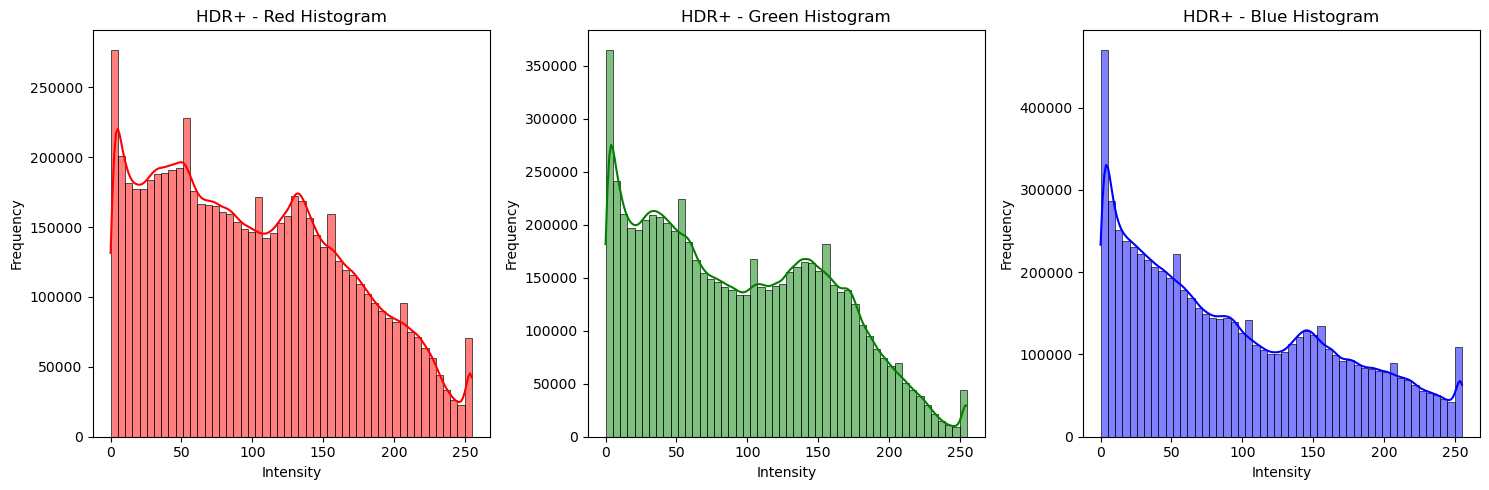

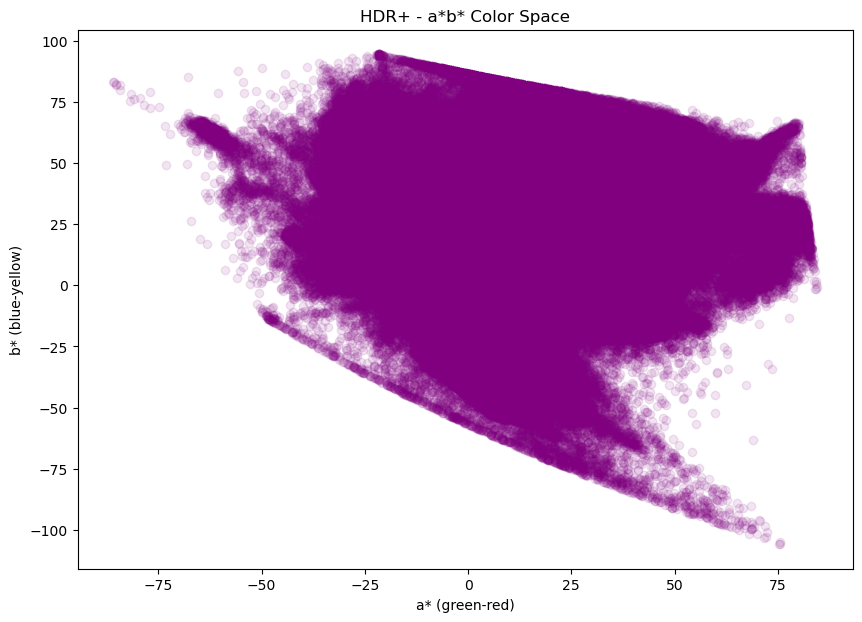

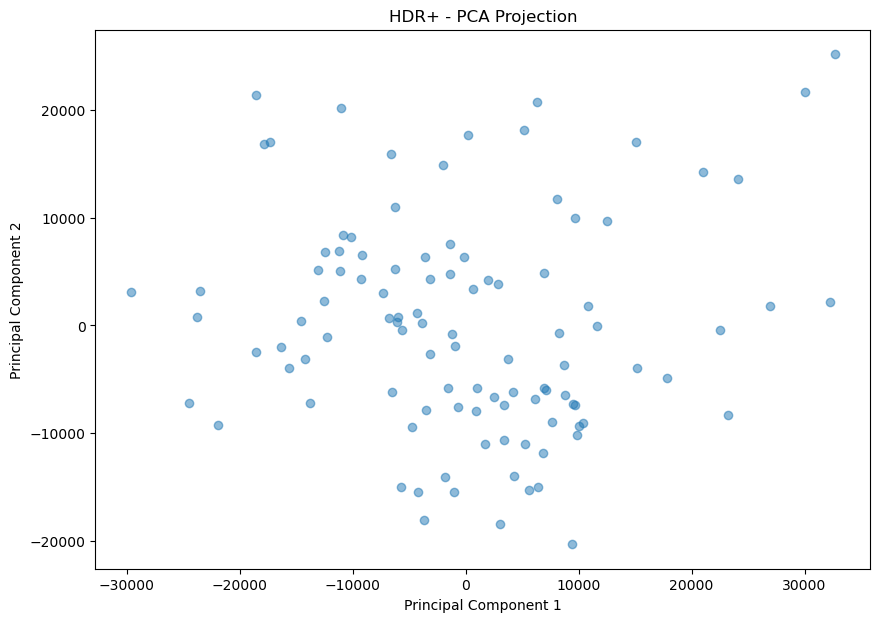

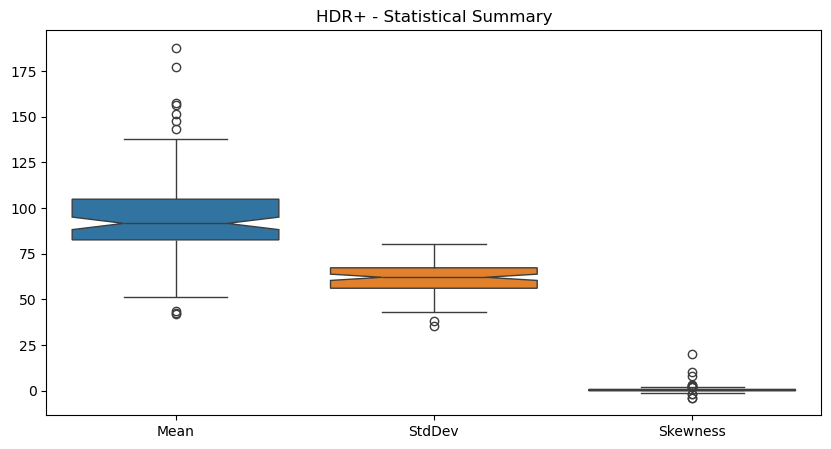

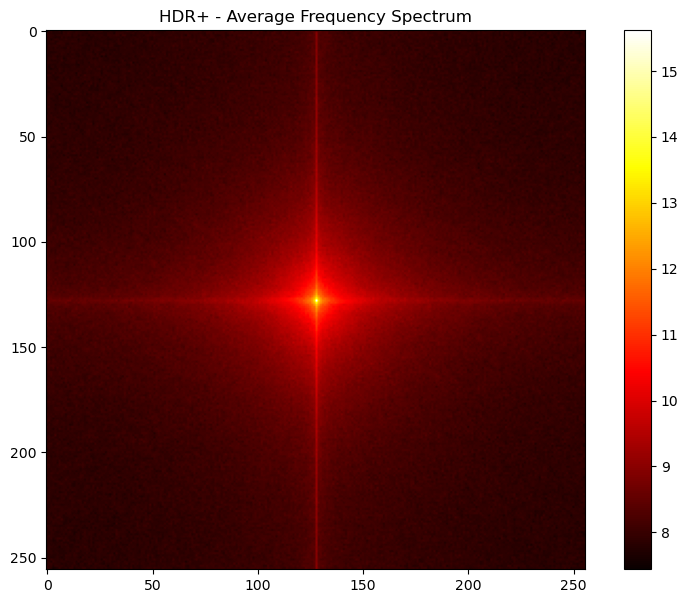

In [6]:
from utils.utils import *
from torch.utils.data import DataLoader

task = "train"
load_train_a0 = Atmospheric_Dataset(atmospheric_dataset_name="HDR+",task=task)

train_dataset_atmospheric_HDR = DataLoader(load_train_a0, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)

print(f"""Dados de {task}
HDR+ {len(load_train_a0)}
""")
analyze_dataset(train_dataset_atmospheric_HDR, "HDR+")

In [2]:
from utils.utils import *
from torch.utils.data import DataLoader

task = "test"
load_train_0 = Underwater_Dataset(underwater_dataset_name="HICRD",task=task)
load_train_1 = Underwater_Dataset(underwater_dataset_name="LSUI",task=task)
load_train_2 = Underwater_Dataset(underwater_dataset_name="UIEB",task=task)
load_train_3 = Underwater_Dataset(underwater_dataset_name="RUIE",task=task)
load_train_4 = Underwater_Dataset(underwater_dataset_name="EUVP",task=task)

train_dataset_underwater_HICRD = DataLoader(load_train_0, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_LSUI = DataLoader(load_train_1, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_UIEB = DataLoader(load_train_2, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_RUIE = DataLoader(load_train_3, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_EUVP = DataLoader(load_train_4, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
    ###carrega o modelo com as configuracoes indicadas )


load_train_a0 = Atmospheric_Dataset(atmospheric_dataset_name="HDR+",task=task)
load_train_a1 = Atmospheric_Dataset(atmospheric_dataset_name="TM-DIED",task=task)
train_dataset_atmospheric_HDR = DataLoader(load_train_a0, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_atmospheric_tmdied = DataLoader(load_train_a1, batch_size= 8,
                                                shuffle=True, num_workers=4,
                                                drop_last=True, pin_memory=True)
print(f"""Dados de {task}
HDR+ {len(load_train_a0)}
TM-DIED {len(load_train_a1)}
HICRD {len(train_dataset_underwater_HICRD)}
LSUI {len(train_dataset_underwater_LSUI)}
UIEB {len(train_dataset_underwater_UIEB)}
RUIE {len(train_dataset_underwater_RUIE)}
EUVP {len(train_dataset_underwater_EUVP)}
""")


Dados de test
HDR+ 31
TM-DIED 45
HICRD 42
LSUI 107
UIEB 20
RUIE 95
EUVP 225




Analise de dados do dataset HICRD



  0%|          | 0/148 [00:00<?, ?it/s]

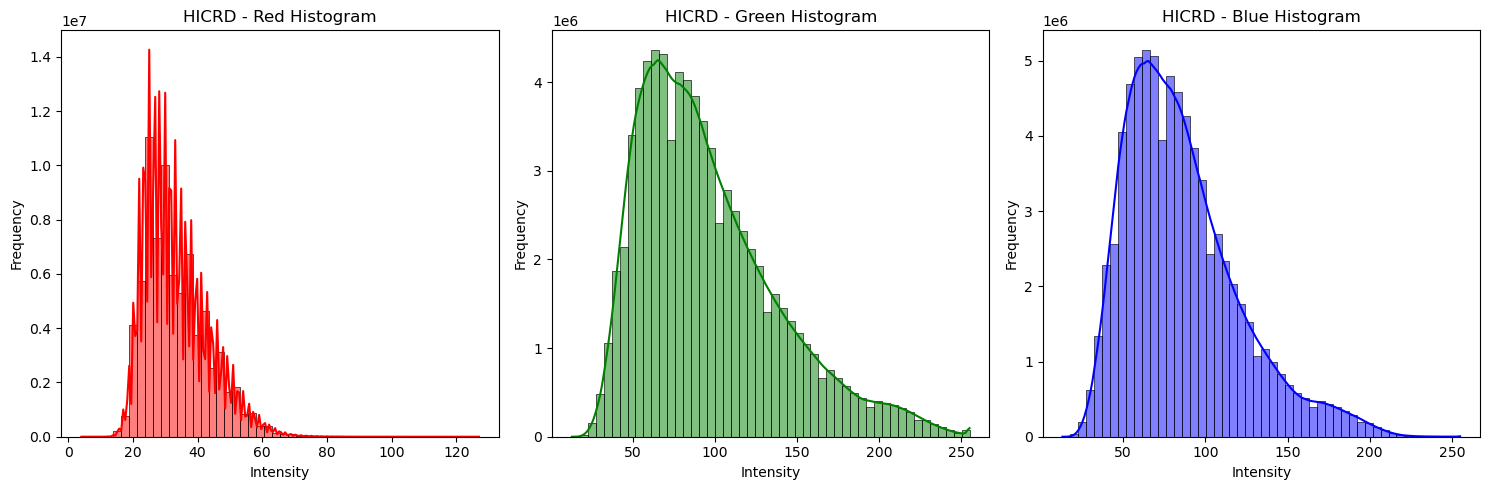

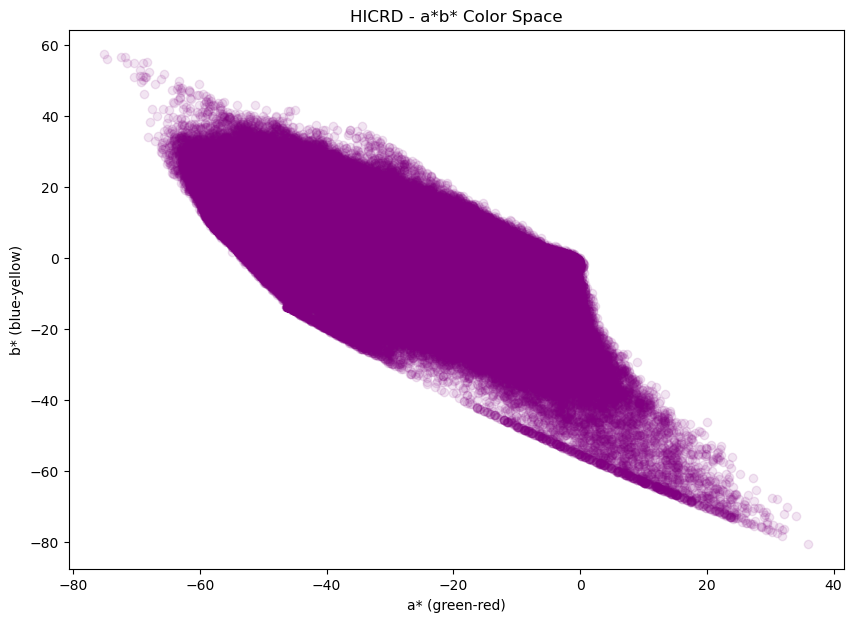

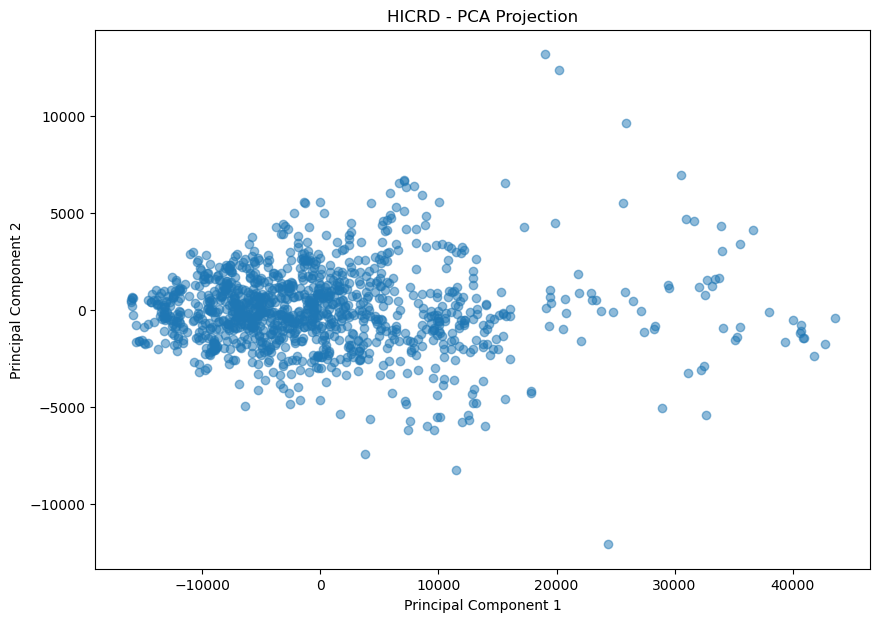

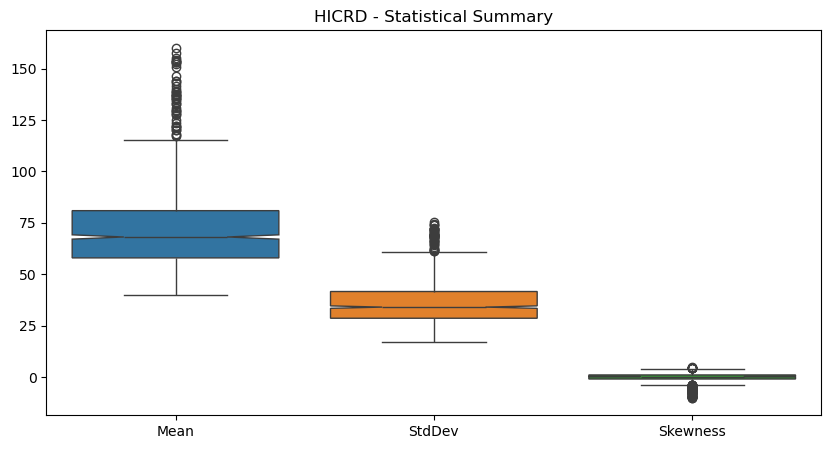

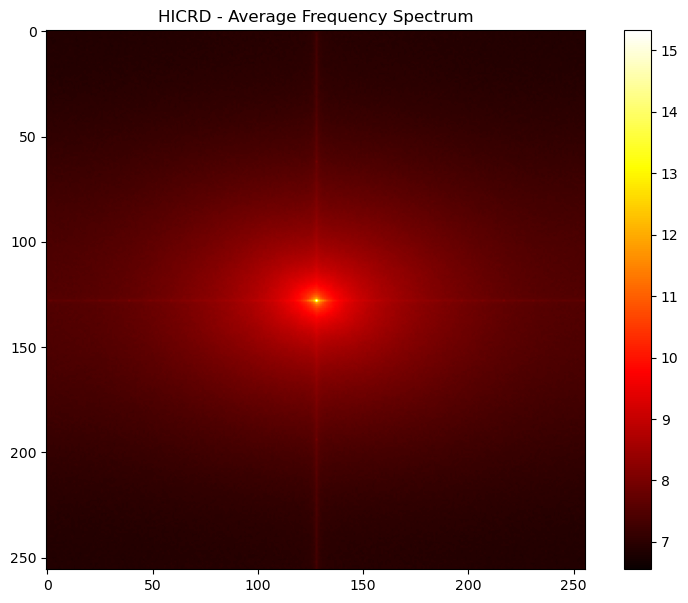


Analise de dados do dataset LSUI



  0%|          | 0/374 [00:00<?, ?it/s]

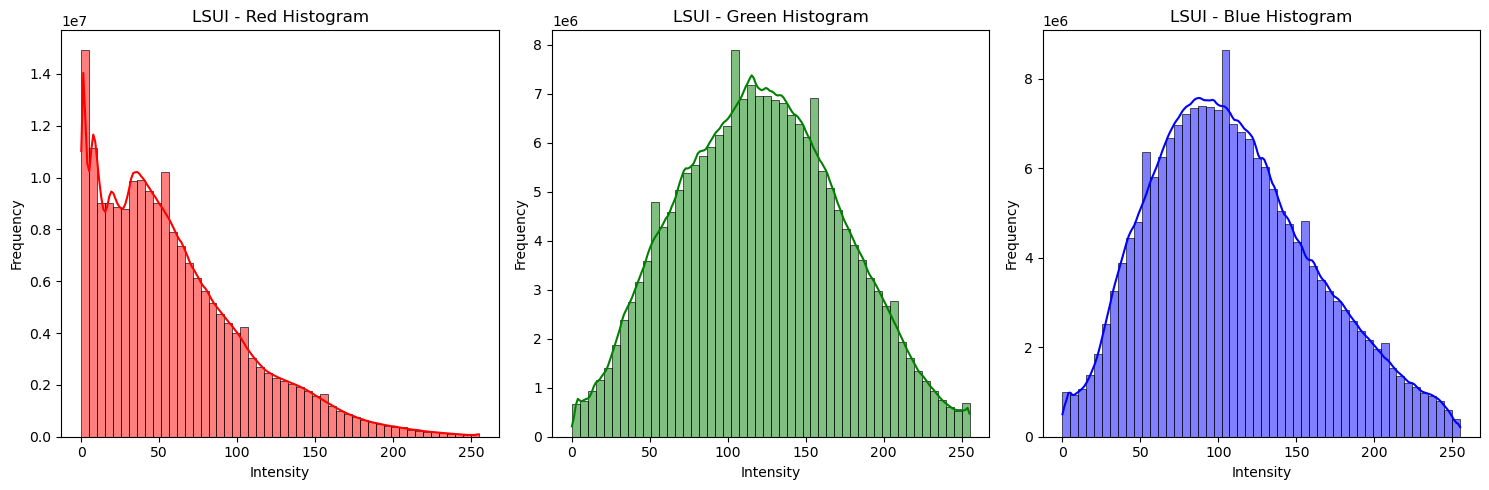

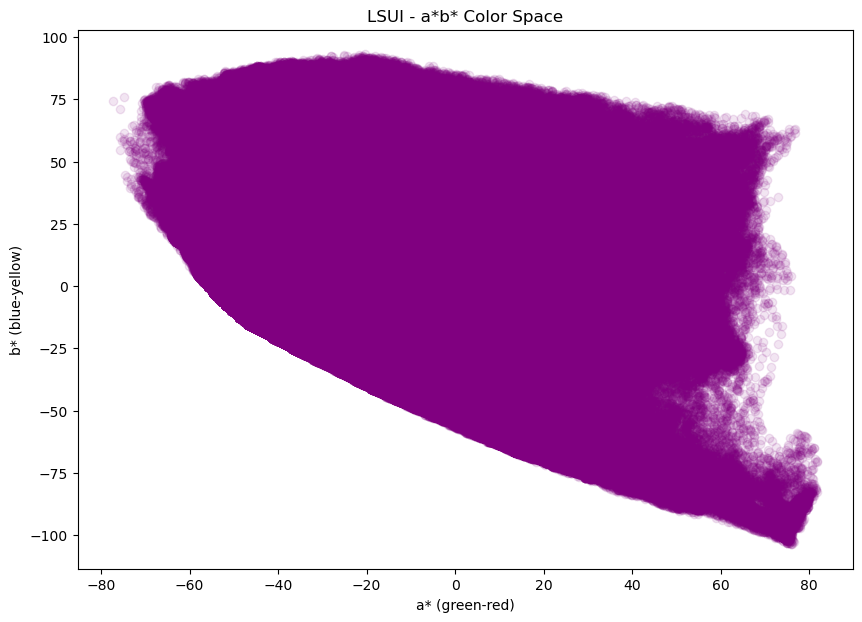

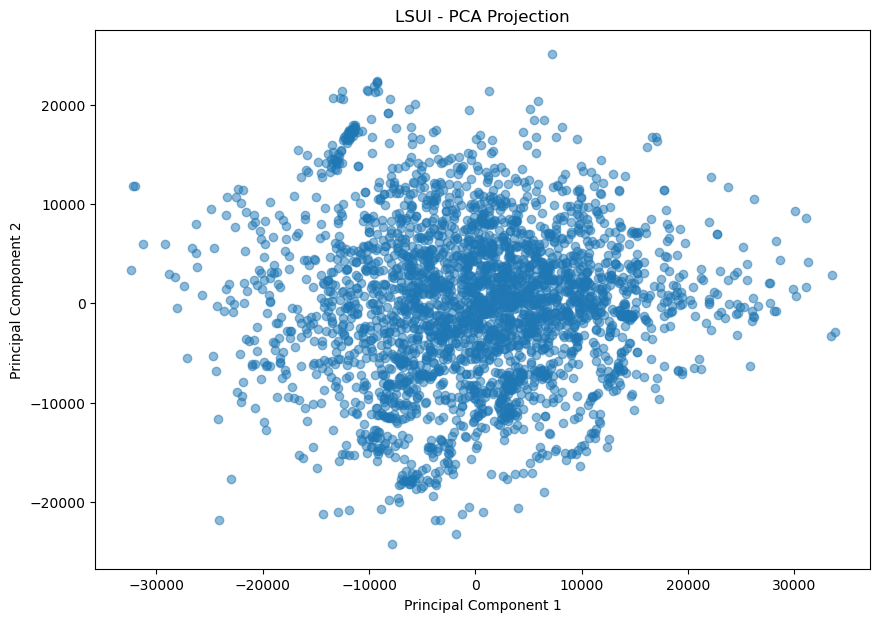

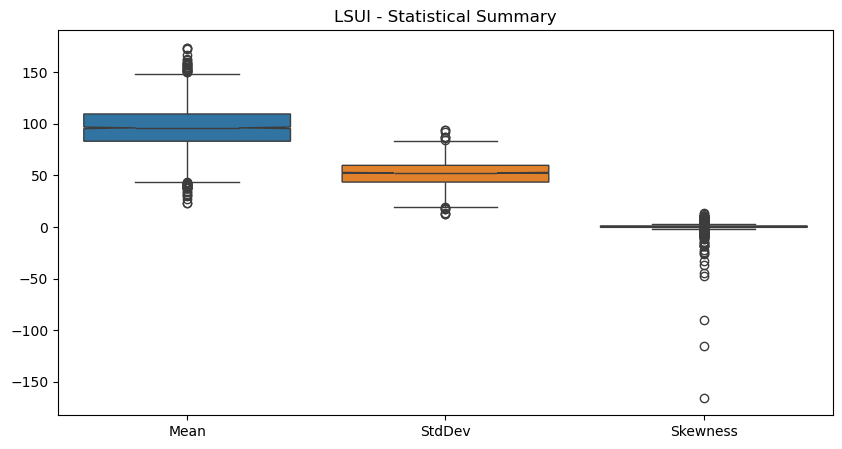

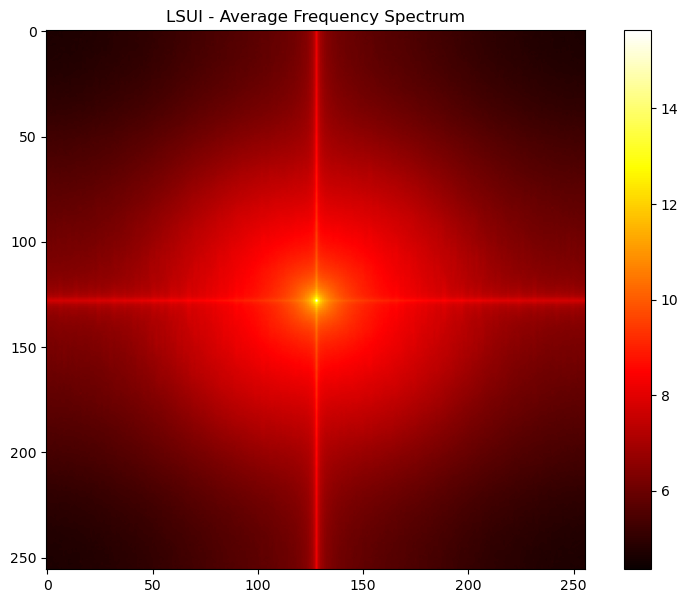


Analise de dados do dataset UIEB



  0%|          | 0/70 [00:00<?, ?it/s]

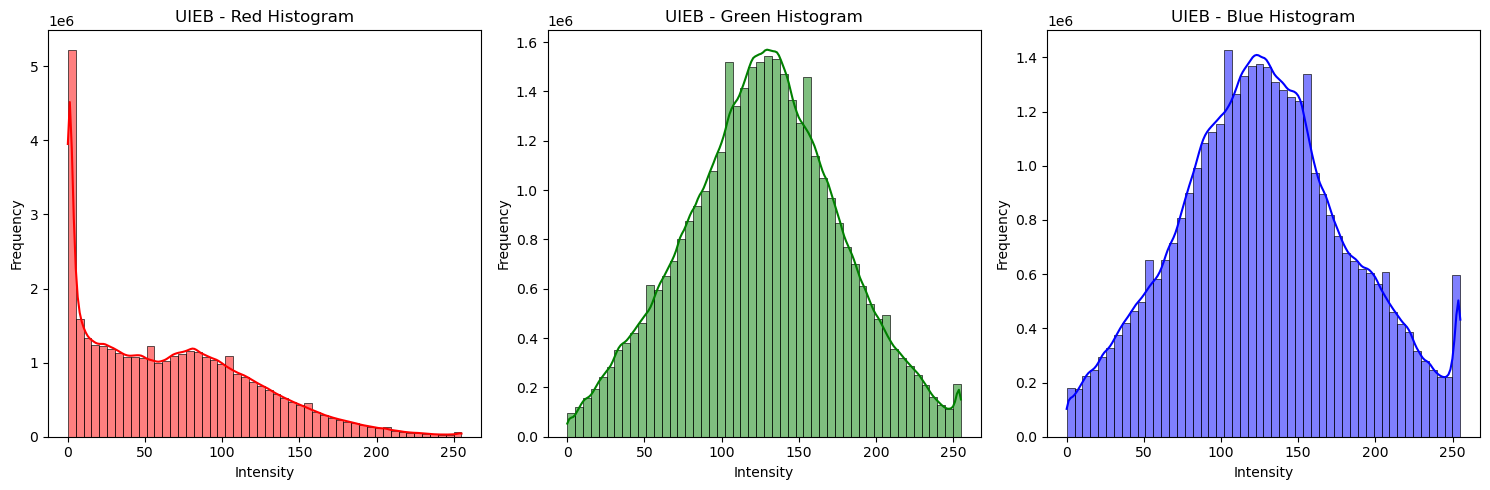

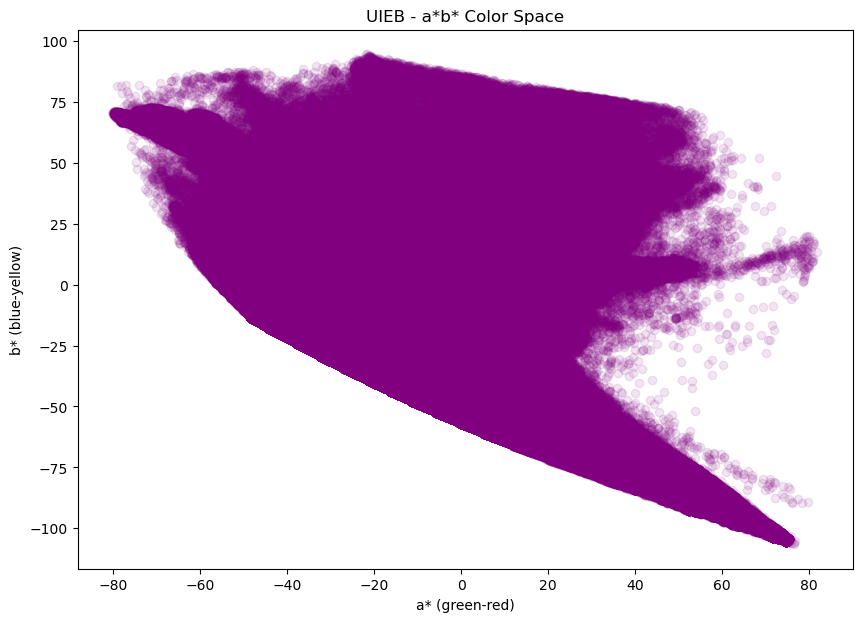

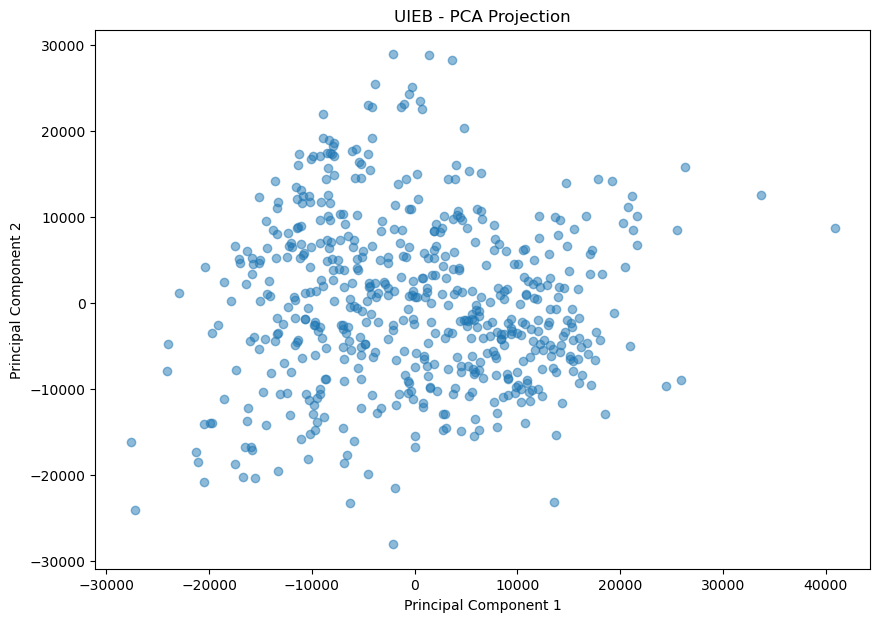

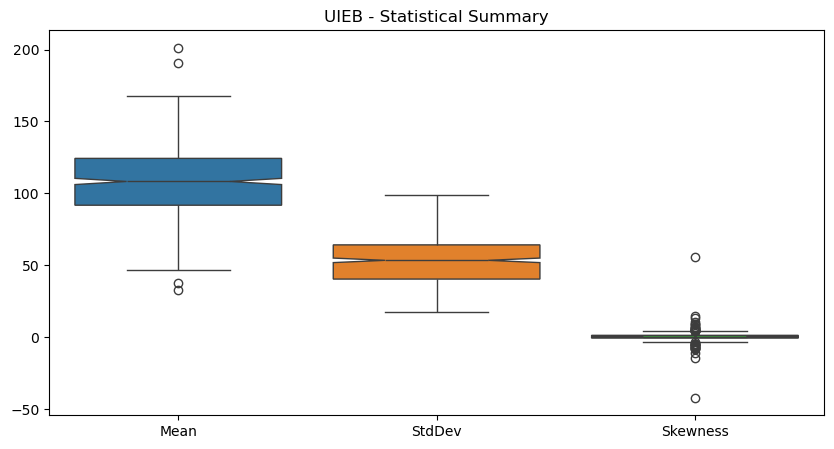

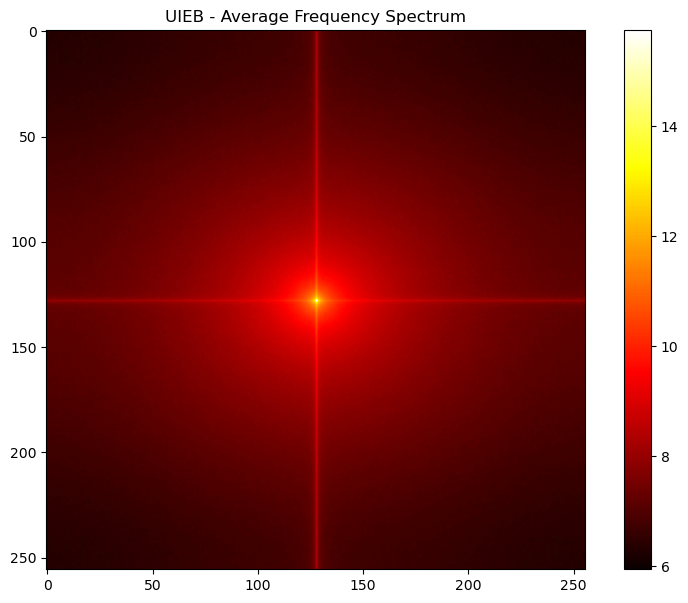


Analise de dados do dataset RUIE



  0%|          | 0/332 [00:00<?, ?it/s]

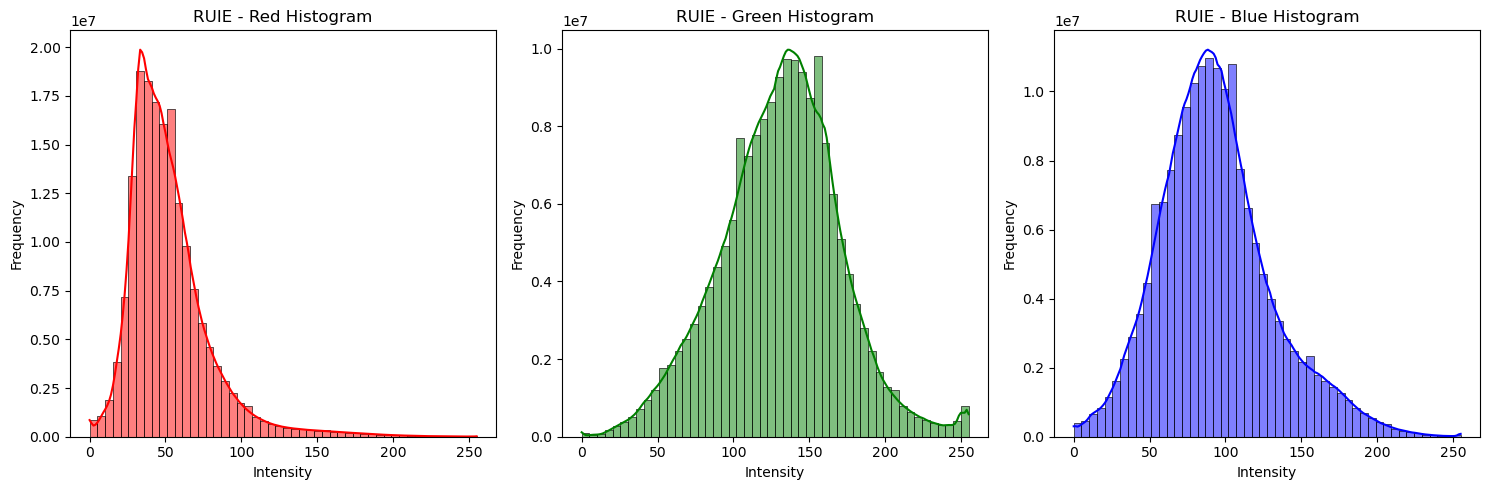

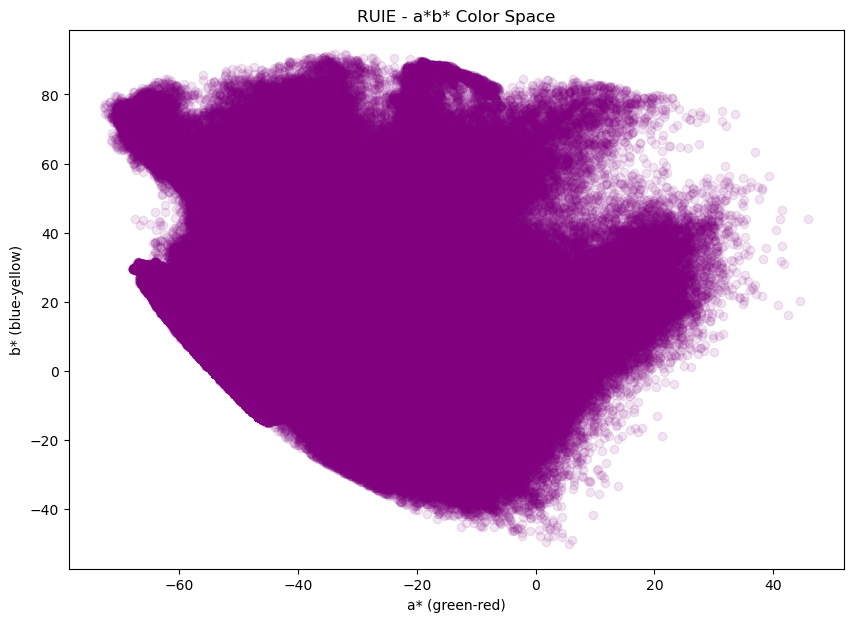

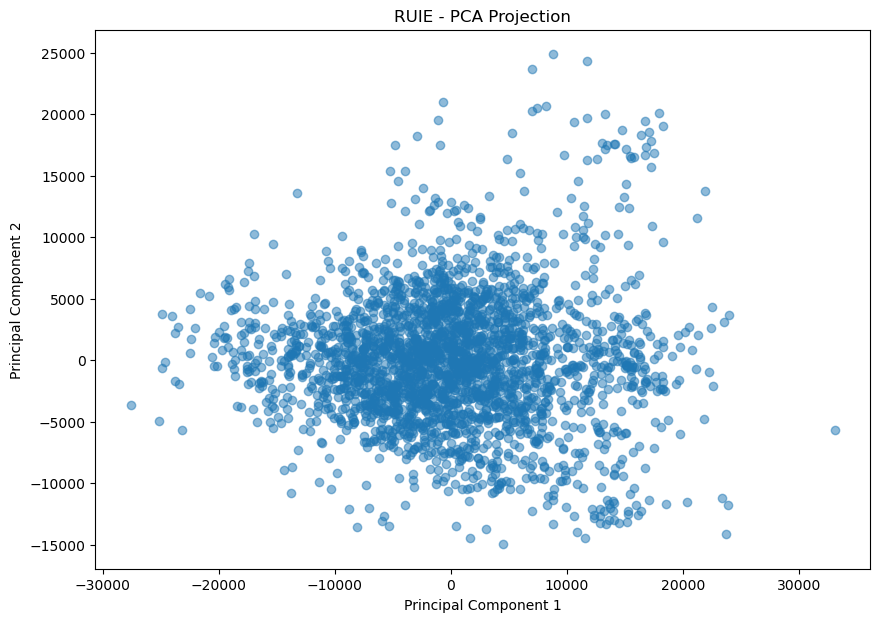

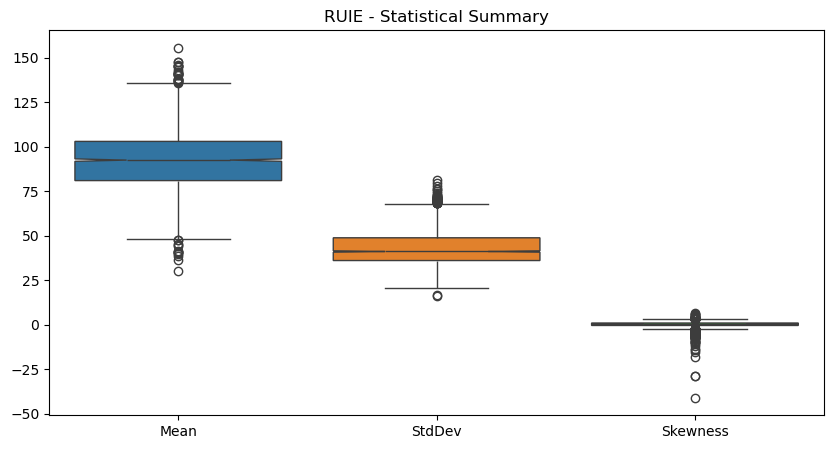

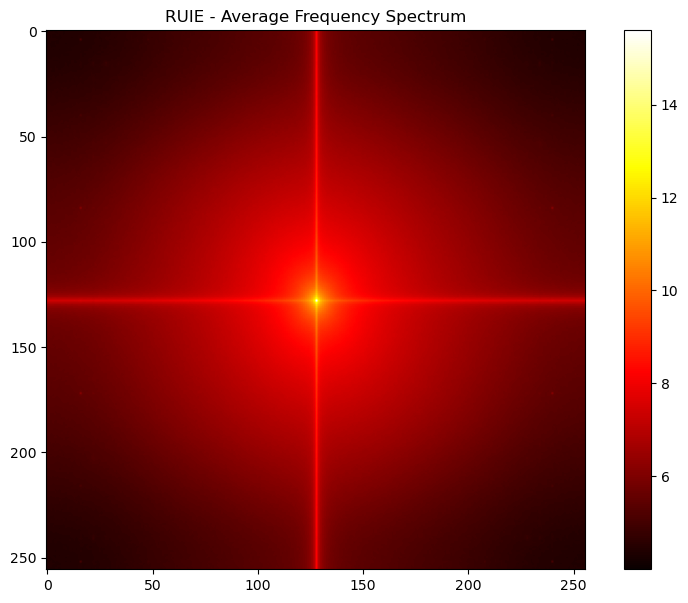


Analise de dados do dataset EUVP



  0%|          | 0/789 [00:00<?, ?it/s]

: 

In [ ]:
dataloaders = {
    "HICRD": train_dataset_underwater_HICRD,
    "LSUI": train_dataset_underwater_LSUI,
    "UIEB": train_dataset_underwater_UIEB,
    "RUIE": train_dataset_underwater_RUIE,
}

for name, dataloader in dataloaders.items():
    analyze_dataset(dataloader, name)



Analise de dados do dataset HDR+



  0%|          | 0/13 [00:00<?, ?it/s]

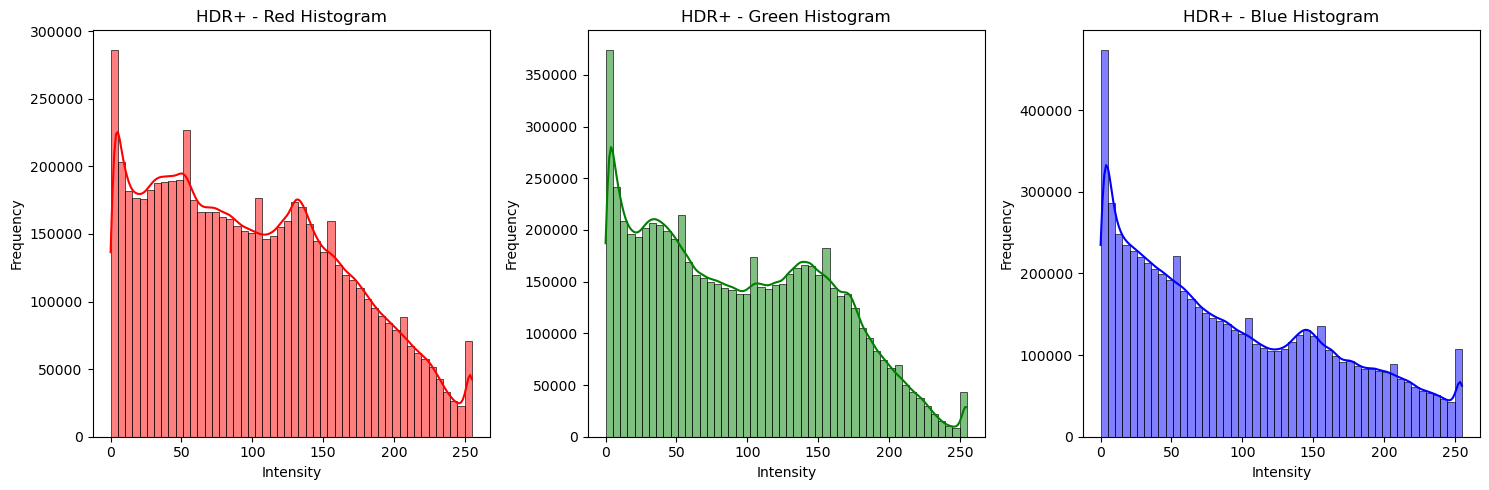

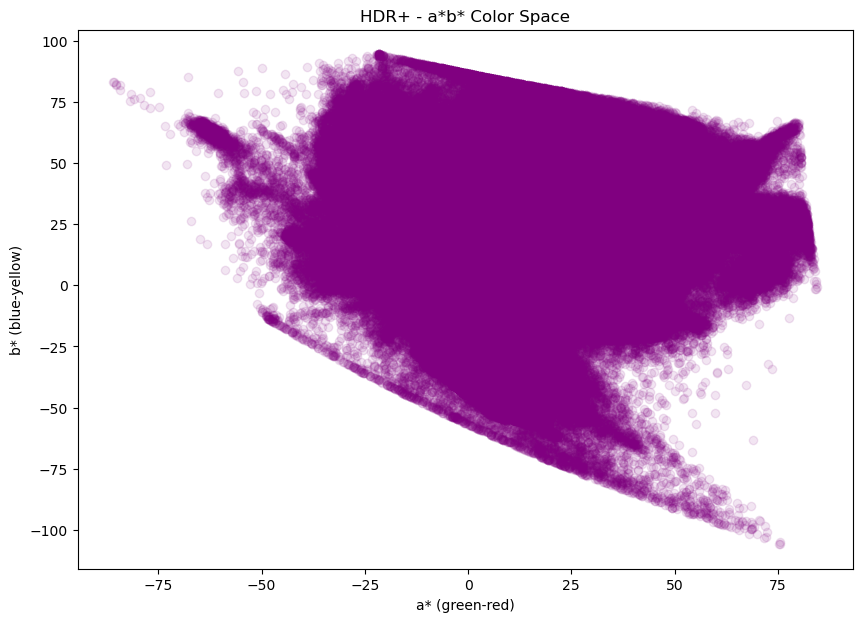

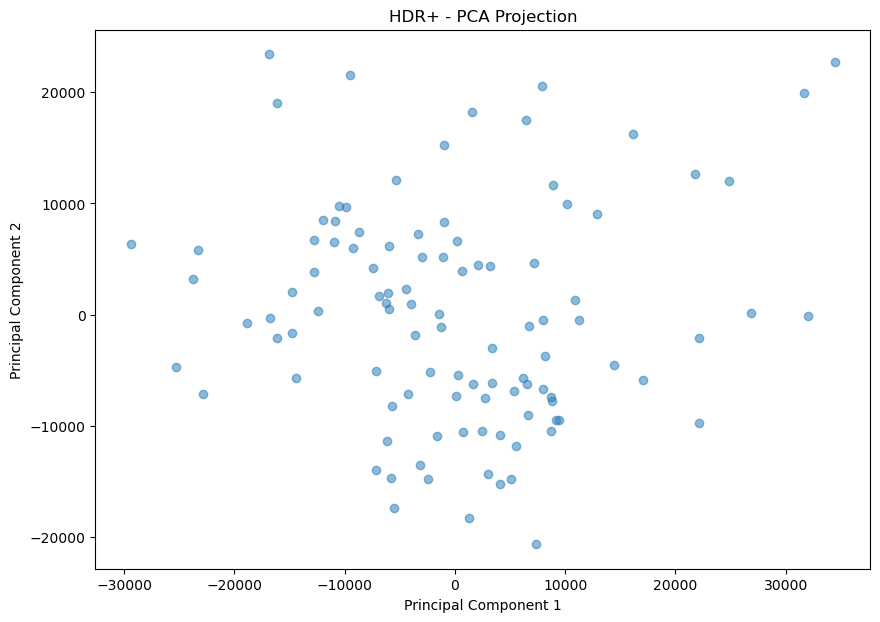

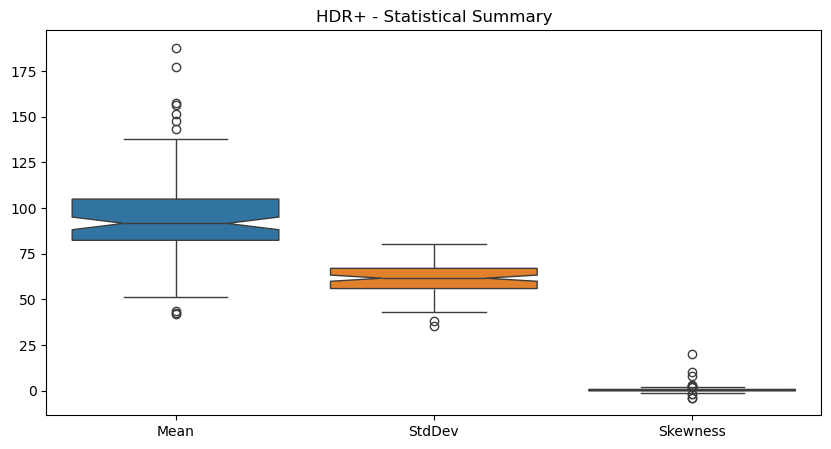

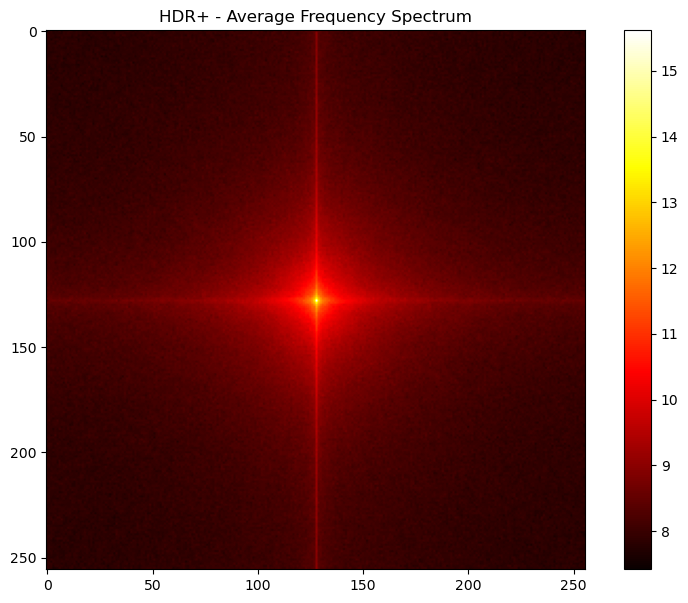


Analise de dados do dataset TM-DIED



  0%|          | 0/19 [00:00<?, ?it/s]

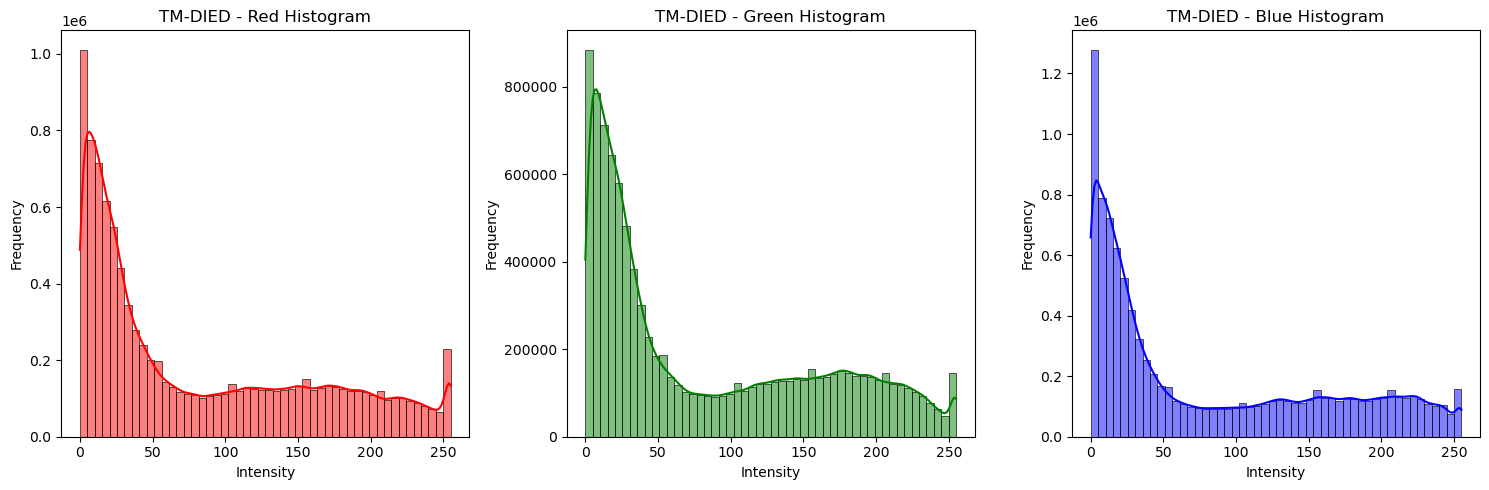

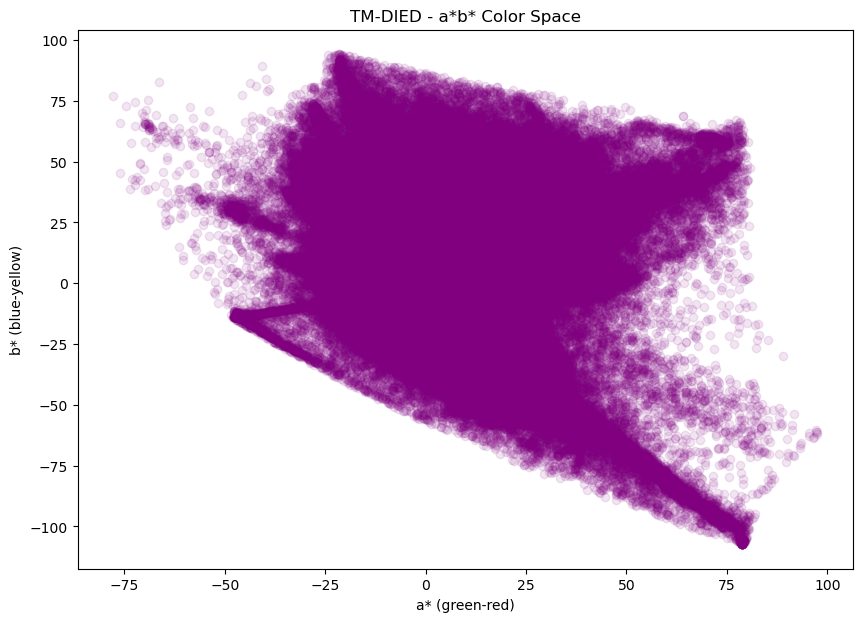

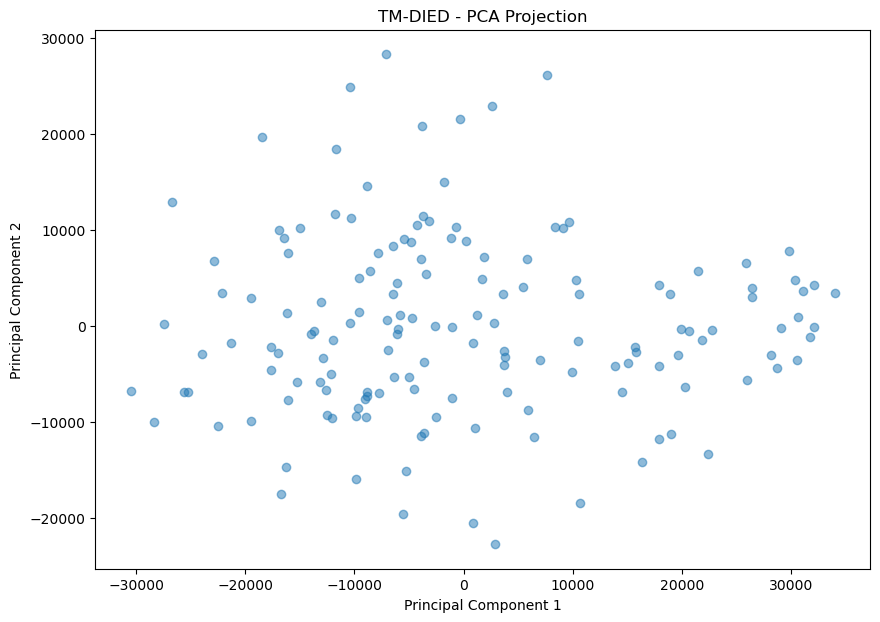

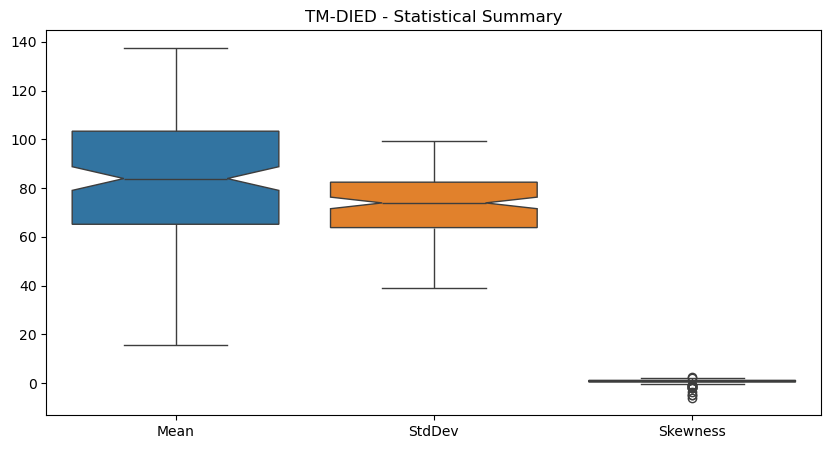

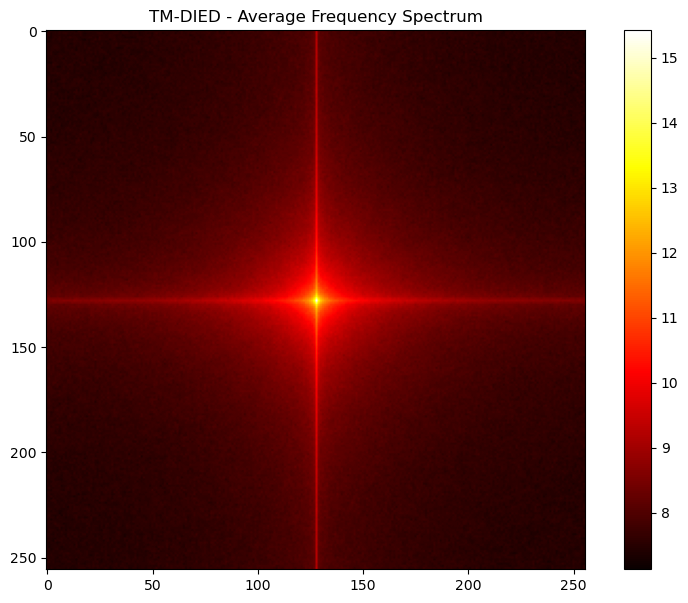

In [3]:
from utils.utils import *
from torch.utils.data import DataLoader

load_train_0 = Underwater_Dataset(underwater_dataset_name="HICRD")
load_train_1 = Underwater_Dataset(underwater_dataset_name="LSUI")
load_train_2 = Underwater_Dataset(underwater_dataset_name="UIEB")
load_train_3 = Underwater_Dataset(underwater_dataset_name="RUIE")
load_train_4 = Underwater_Dataset(underwater_dataset_name="EUVP")

train_dataset_underwater_HICRD = DataLoader(load_train_0, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_LSUI = DataLoader(load_train_1, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_UIEB = DataLoader(load_train_2, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_RUIE = DataLoader(load_train_3, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_underwater_EUVP = DataLoader(load_train_4, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
    ###carrega o modelo com as configuracoes indicadas )


load_train_a0 = Atmospheric_Dataset(atmospheric_dataset_name="HDR+")
load_train_a1 = Atmospheric_Dataset(atmospheric_dataset_name="TM-DIED")
train_dataset_atmospheric_HDR = DataLoader(load_train_a0, batch_size= 8,
                                            shuffle=True, num_workers=4,
                                            drop_last=True, pin_memory=True)
train_dataset_atmospheric_tmdied = DataLoader(load_train_a1, batch_size= 8,
                                                shuffle=True, num_workers=4,
                                                drop_last=True, pin_memory=True)



dataloaders = {
    "HDR+": train_dataset_atmospheric_HDR,
    "TM-DIED": train_dataset_atmospheric_tmdied
}

for name, dataloader in dataloaders.items():
    analyze_dataset(dataloader, name)
